# ConvCNP for Interpolating Temperature from Sensor Readings and ERA5

The first small-scale experiment to use a ConvCNP to interpolate sensor temperature readings, with topography, ERA5, and sensor layers.

In [1]:
import sys
from pathlib import Path

# Make project root importable
ROOT = Path().resolve().parents[1]
sys.path.append(str(ROOT))

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from src.utils.variables.var_names import *
from src.utils.variables.coord_names import *
from src.data_processing.conversions.scalar_conversions import *
from src.config.env_loader import get_env_var

from src.data_processing.station_processor import ProcessStations
from src.data_processing.topology_processor import ProcessTopography
from src.data_processing.era5_processor import ProcessERA5

In [4]:
# DeepSensor imports
import deepsensor.torch
from deepsensor.train.train import train_epoch, set_gpu_default_device
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.basemap import Basemap

In [5]:
# setup variables for experiment
var = TEMPERATURE
years = [2010, 2011, 2012, 2013, 2014]

train_years = [2010] #[2010, 2011, 2012, 2013]
validation_years = [2014]

# GPU settings
use_gpu = True
if use_gpu:
    set_gpu_default_device()

# visualisations of data
DEBUG_PLOTS = True

In [6]:
# load datasets
station_processor = ProcessStations()
topography_processor = ProcessTopography()
era5_processor = ProcessERA5()


In [7]:
# topography and ERA5 datasets are loaded as simple xarray datasets
topography_ds = topography_processor.load_ds(standardise_var_names=True, standardise_coord_names=True)
era5_ds = era5_processor.load_ds(mode="surface", years=years, standardise_var_names=True, standardise_coord_names=True)

### Cleanup & validation of ERA5 Data

In [8]:
# clean up the ERA5 data:
era5_da = era5_processor.get_variable(era5_ds, var) # set variable to process - e.g. "temperature"
era5_da = kelvin_to_celsius(era5_da)

# coarsen ERA5
era5_da_coarsen = era5_da.coarsen(lat=2, lon=2, boundary='trim').mean()

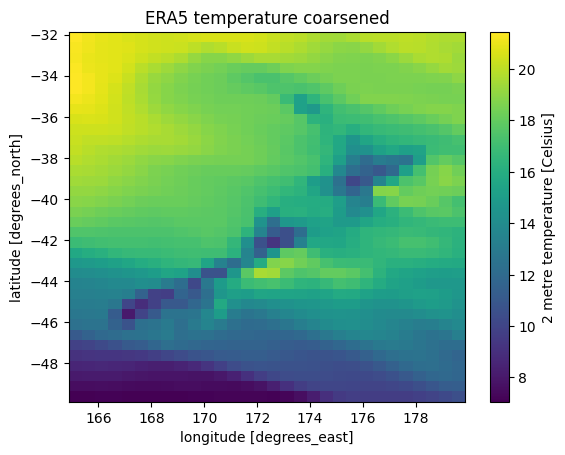

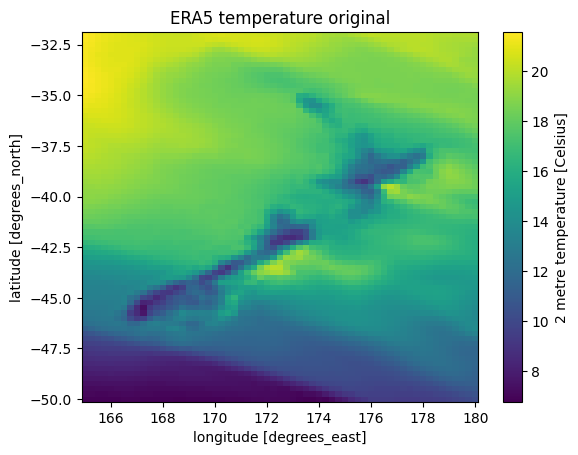

In [9]:
if DEBUG_PLOTS:
    # visual check of correctness
    era5_da_coarsen.sel(time="2010-01-01T18:00").plot()
    plt.title(f"ERA5 {var} coarsened")
    plt.show()

    era5_da.sel(time="2010-01-01T18:00").plot()
    plt.title(f"ERA5 {var} original")
    plt.show()

### Cleanup & Validation of Topographical Data

In [10]:
# Compute the topographic position index (TPI) from elevation data
ds_tpi = topography_processor.compute_tpi(topography_ds)

# coarsen the elevation data
topo_coarse = topography_ds.coarsen(lat=20, lon=20, boundary='trim').mean()[ELEVATION]

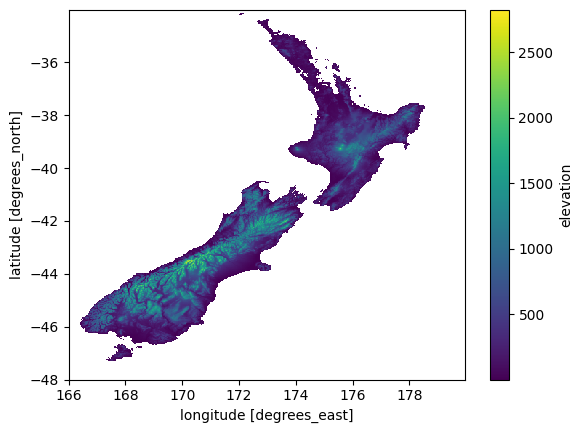

In [11]:
if DEBUG_PLOTS:
    topo_coarse.plot()

In [12]:
# fill elevation Nans with 0's (ocean areas)
topography_ds = topography_ds.fillna(0)
topo_coarse = topo_coarse.fillna(0)

### Load the stations
Not all stations load temperature across all timestamps.

Desired data format:

| lat | long | time | temperature |
|:---:|:----:|:----:|:-----------:|
| float | float | timestamp | float |
| float | float | timestamp | float |

In [13]:
# load the stations with the variable of interest between the start and end years
stations_df = station_processor.load_df(vars=[var], year_start=2010, year_end=2014)

/home/lennoxc/niwa/convcnp-assim-nz/src/data_processing/station_processor.py:157: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  ds_comb = xr.concat([first, *station_iter], dim="station")


In [14]:
stations_df.head()
stations_reset = stations_df.reset_index()
stations_reset.drop(columns=['station'], inplace=True)

In [15]:
# resample to six-hourly frequency to match ERA5 timestamps
stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[['temperature']]
stations_resample = stations_resample.reset_index().set_index(['time', 'lat', 'lon']).sort_index()

/tmp/ipykernel_40741/3879327337.py:2: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[['temperature']]


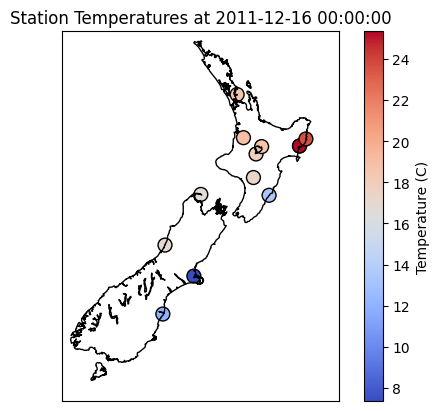

In [16]:
# plot temperature across all locations using temperature colormap at a single time step
# plot on a map of NZ using basemap
time_step = "2011-12-16 00:00:00"
m = Basemap(projection='merc', llcrnrlat=-48, urcrnrlat=-34, llcrnrlon=166, urcrnrlon=180, resolution='i')
m.drawcoastlines()
m.drawcountries()
x, y = m(stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lon'].values,
           stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lat'].values)
sc = m.scatter(x, y,
               c=stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['temperature'].values,
               cmap='coolwarm', marker='o', edgecolor='k', s=100)
plt.colorbar(sc, label='Temperature (C)')
plt.title(f'Station Temperatures at {time_step}')
plt.show()

### Ensure compatibility of layers

In [17]:
# slice the ERA5 data to match the topography extent
era5_da = era5_da.sel(lat=slice(topo_coarse[LATITUDE].max(), topo_coarse[LATITUDE].min()), lon=slice(topo_coarse[LONGITUDE].min(), topo_coarse[LONGITUDE].max()))

### Normalisation and Preprocessing

In [18]:
data_processor = DataProcessor(x1_name=LATITUDE, x1_map=(era5_da[LATITUDE].min(), era5_da[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_da[LONGITUDE].min(), era5_da[LONGITUDE].max()))

In [19]:
era5_processed, station_processed = data_processor([era5_da, stations_resample])

In [20]:
aux_highres_processed, aux_processed = data_processor([topography_ds, topo_coarse], method='min_max')

In [21]:
print(data_processor)

DataProcessor with normalisation params:
{'coords': {'time': {'name': 'time'},
            'x1': {'map': (-47.75, -34.25), 'name': 'lat'},
            'x2': {'map': (166.25, 179.75), 'name': 'lon'}},
 'elevation': {'method': 'min_max',
               'params': {'max': 3655.506591796875,
                          'min': -26.582759857177734}},
 'temperature': {'method': 'mean_std',
                 'params': {'mean': 13.501922607421875,
                            'std': 4.209717750549316}},
 'tpi_ws0.025': {'method': 'min_max',
                 'params': {'max': 1339.210205078125,
                            'min': -789.6385498046875}},
 'tpi_ws0.05': {'method': 'min_max',
                'params': {'max': 1790.2523193359375,
                           'min': -940.9993286132812}},
 'tpi_ws0.1': {'method': 'min_max',
               'params': {'max': 1588.9427490234375,
                          'min': -904.8171997070312}}}


In [22]:
from deepsensor.data.utils import construct_x1x2_ds

x1x2_ds = construct_x1x2_ds(aux_processed)
aux_processed['x1_arr'] = x1x2_ds['x1_arr']
aux_processed['x2_arr'] = x1x2_ds['x2_arr']
aux_processed

<xarray.DataArray 'elevation' (x1: 546, x2: 546)> Size: 1MB
array([[-0.9855611, -0.9855611, -0.9855611, ..., -0.9855611, -0.9855611,
        -0.9855611],
       [-0.9855611, -0.9855611, -0.9855611, ..., -0.9855611, -0.9855611,
        -0.9855611],
       [-0.9855611, -0.9855611, -0.9855611, ..., -0.9855611, -0.9855611,
        -0.9855611],
       ...,
       [-0.9855611, -0.9855611, -0.9855611, ..., -0.9855611, -0.9855611,
        -0.9855611],
       [-0.9855611, -0.9855611, -0.9855611, ..., -0.9855611, -0.9855611,
        -0.9855611],
       [-0.9855611, -0.9855611, -0.9855611, ..., -0.9855611, -0.9855611,
        -0.9855611]], shape=(546, 546), dtype=float32)
Coordinates:
  * x1       (x1) float32 2kB -0.01762 -0.01572 -0.01383 ... 1.012 1.014 1.016
  * x2       (x2) float32 2kB -0.01757 -0.01567 -0.01378 ... 1.012 1.014 1.016
    x1_arr   (x1, x2) float32 1MB -0.01762 -0.01762 -0.01762 ... 1.016 1.016
    x2_arr   (x1, x2) float32 1MB -0.01757 -0.01567 -0.01378 ... 1.014 1.016

In [23]:
# this doesn't use any stations in the context set.
# this should be updated for data assimilation experiments later.
task_loader = TaskLoader(context=[era5_processed, aux_processed], target=station_processed, aux_at_targets=aux_highres_processed)

In [24]:
model = ConvNP(data_processor, task_loader, unet_channels=(64,)*3, likelihood="gnp")

dim_yc inferred from TaskLoader: (1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 4
Setting aux_t_mlp_layers: (64, 64, 64)
internal_density inferred from TaskLoader: 5288
encoder_scales inferred from TaskLoader: [np.float32(0.009259258), np.float32(0.0009481479)]
decoder_scale inferred from TaskLoader: 0.00018910741301059002


In [25]:
task_loader.load_dask()

In [26]:
train_dates = era5_da.sel(time=slice("2010-01-01", "2011-12-31")).time.values
val_dates = era5_da.sel(time=slice("2012-01-01", "2012-06-30")).time.values

In [27]:
from tqdm import tqdm
train_tasks = []
for date in tqdm(train_dates[::2]):
    task = task_loader(date, context_sampling="all", target_sampling="all")
    train_tasks.append(task)

val_tasks = []
for date in tqdm(val_dates):
    task = task_loader(date, context_sampling="all", target_sampling="all")
    val_tasks.append(task)

  0%|          | 0/1460 [00:00<?, ?it/s]

100%|██████████| 728/728 [00:03<00:00, 212.09it/s]


In [28]:
train_tasks[0]

time: Timestamp/2010-01-01 00:00:00
ops: []
X_c: [('ndarray/float32/(1, 55)', 'ndarray/float32/(1, 55)'), ('ndarray/float32/(1, 546)', 'ndarray/float32/(1, 546)')]
Y_c: ['ndarray/float32/(1, 55, 55)', 'ndarray/float32/(1, 546, 546)']
X_t: ['ndarray/float32/(2, 12)']
Y_t: ['ndarray/float32/(1, 12)']
Y_t_aux: ndarray/float32/(4, 12)

/home/lennoxc/niwa/convcnp-assim-nz/venv/lib/python3.12/site-packages/lab/types.py:204: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:


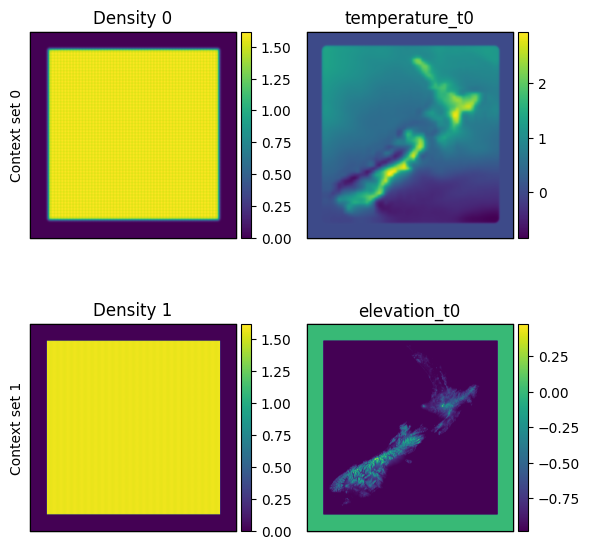

In [29]:
fig = deepsensor.plot.context_encoding(model, train_tasks[0], task_loader)

In [30]:
import lab as B
def compute_val_loss(model, val_tasks):
    val_losses = []
    for task in val_tasks:
        val_losses.append(B.to_numpy(model.loss_fn(task, normalise=True)))
    return np.mean(val_losses)

In [31]:
from tqdm import tqdm

n_epochs = 2
train_losses = []
val_losses = []

val_loss_best = np.inf

for epoch in tqdm(range(n_epochs)):
    batch_losses = train_epoch(model, train_tasks)
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    val_loss = compute_val_loss(model, val_tasks)
    val_losses.append(val_loss)

    if val_loss < val_loss_best:
        import torch
        import os
        val_loss_best = val_loss
        folder = os.path.join(get_env_var("PROJECT_ROOT"), "models", "downscaling", "temperature", "convcnp")
        if not os.path.exists(folder): os.makedirs(folder)
        torch.save(model.model.state_dict(), folder + f"model.pt")

    print(f"Epoch {epoch} train_loss: {train_loss:.2f}, val_loss: {val_loss:.2f}")

  0%|          | 0/2 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 10.16 GiB. GPU 0 has a total capacity of 11.63 GiB of which 9.56 GiB is free. Including non-PyTorch memory, this process has 2.06 GiB memory in use. Of the allocated memory 1.92 GiB is allocated by PyTorch, and 14.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)